#DATA 410 Lecture 17 - Spring 2022

<font face="Chalkboard" color="darkgreen" size=10>Data Applications with Variable Selection Algorithms</font>

## Data Simulations for Linear Regression & Variable Selection/Regularization

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [ ]:
# This is important: update the statsmodels package
#! pip install --upgrade Cython
#! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm

In [ ]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import toeplitz
from matplotlib import pyplot

## For simulating multiple correlations we can use a Toeplitz matrix

## What is the connection between correlation and covariance?

$$\mbox{corr}(X,Y) = \frac{\mbox{Cov(X,Y)}}{\sigma_X\cdot\sigma_Y}$$

In [ ]:
# we want to define a function for generating X with a prescribed number of obsvervations, features and Toeplitz correlation structure.
def make_correlated_features(num_samples,p,rho):
  vcor = [] 
  for i in range(p):
    vcor.append(rho**i)
  r = toeplitz(vcor)
  mu = np.repeat(0,p)
  X = np.random.multivariate_normal(mu, r, size=num_samples)
  return X

In [ ]:
# the number of feautures is p and n is the number of observations
n = 200
p = 50
X = make_correlated_features(200,p,0.8)

In [ ]:
np.corrcoef(np.transpose(X))

## Simulate some ground truth:

The is supposed to be linear: 

$$\large y = X\cdot \beta^* +\sigma\epsilon$$



In [ ]:
beta =np.array([-1,2,3,0,0,0,0,2,-1,4])
beta.shape

(10,)

In [ ]:
beta = beta.reshape(-1,1)
betas = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)

In [ ]:
# this is our simulated ground truth
betas.shape

(50, 1)

In [ ]:
n = 200
sigma = 2
y = X.dot(betas) + sigma*np.random.normal(0,1,n).reshape(-1,1)

## Square Root Lasso

https://arxiv.org/abs/1009.5689

*Square Root Lasso* is also based on minimizing an objective function plus a $L_1$ constraint (penalty).

For example, *Square Root Lasso* is represented by the following optimization problem:

$$
\displaystyle\text{minimize} \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n}(y_i-\hat{y}_i)^2} +\alpha\sum\limits_{i=1}^{p}|\beta_i|
$$

In [ ]:
# here alpha is a hyperparameter
model = sm.OLS(y,X)
result = model.fit_regularized(method='sqrt_lasso', alpha=4,profile_scale=True)
betahat = result.params

# we can compare the output with the ground truth betas via an L1 or an L2 norm:

# via L1
np.sum(np.abs(betahat-betas))

# via L2 norm
np.sqrt(np.sum((betahat-betas)**2))

56.50252640856572

In [ ]:
betahat[np.abs(betahat)<1e-3]=0

56.50252759453032

In [ ]:
def sqrtLasso(X,y,alpha):
    model = sm.OLS(y,X)
    result = model.fit_regularized(method='sqrt_lasso', alpha=alpha,profile_scale=True)
    return result.predict(X), result.params

In [ ]:
df = pd.read_csv('drive/MyDrive/Data Sets/Boston Housing Prices.csv')
features = ['crime','rooms','residential','industrial','nox','older','distance','highway','tax','ptratio','lstat']
X = np.array(df[features])
y = np.array(df['cmedv']).reshape(-1,1)

In [ ]:
df

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Winthrop,1801,-70.986000,42.231201,0.06263,0.0,11.93,no,0.573,6.593,69.099998,2.4786,1,273,21.000000,9.67,22.400000
502,Winthrop,1802,-70.990997,42.227501,0.04527,0.0,11.93,no,0.573,6.120,76.699997,2.2875,1,273,21.000000,9.08,20.600000
503,Winthrop,1803,-70.994797,42.226002,0.06076,0.0,11.93,no,0.573,6.976,91.000000,2.1675,1,273,21.000000,5.64,23.900000
504,Winthrop,1804,-70.987503,42.223999,0.10959,0.0,11.93,no,0.573,6.794,89.300003,2.3889,1,273,21.000000,6.48,22.000000


In [ ]:
from sklearn.model_selection import train_test_split as tts

In [ ]:
X_train, X_test, y_train, y_test = tts(X,y,test_size=0.3,random_state=1234)

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler

In [ ]:
model = sm.OLS(y_train,X_train)
result = model.fit_regularized(method='sqrt_lasso', alpha=0.5)
yhat_test = result.predict(X_test)
1000*MAE(y_test,yhat_test)

3393.4313897309585

In [ ]:
scale = StandardScaler()
Xs_train = scale.fit_transform(X_train)
Xs_test  = scale.transform(X_test)

In [ ]:
model = sm.OLS(y_train,Xs_train)
#result = model.fit()
result = model.fit_regularized(method='elastic_net', alpha=0.5,L1_wt=0.5)
yhat_test = result.predict(Xs_test)
1000*MAE(y_test,yhat_test)

22560.78482808174

In [ ]:
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

In [ ]:
model = Lasso(alpha=0.5)
result = model.fit(Xs_train,y_train)
yhat_test = result.predict(Xs_test)
1000*MAE(y_test,yhat_test)

3728.1436091653027

In [ ]:
model = ElasticNet(alpha=0.5,l1_ratio=0.5)
result = model.fit(Xs_train,y_train)
yhat_test = result.predict(Xs_test)
1000*MAE(y_test,yhat_test)

3632.161735858232

## How to implement your own sklearn estimator

http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/ For bonus points

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=1234)

In [ ]:
alphas = np.arange(0,10,0.1)

In [ ]:
def DoKFold(X,y,alpha):
  MSE = []
  for idxtrain, idxtest in kf.split(X):
    X_train = X[idxtrain,:]
    y_train = y[idxtrain]
    X_test  = X[idxtest,:]
    y_test  = y[idxtest]
    model = sm.OLS(y_train,X_train)
    result = model.fit_regularized(method='sqrt_lasso', alpha=alpha,profile_scale=True)
    yhat_test = result.predict(X_test)
    MSE.append(np.sum((y_test-yhat_test)**2))
  return np.sqrt(np.mean(MSE))

In [ ]:
# we get the 5-fold crossvalidated Root Mean Squared Error:
cv_rmse =[]
for i in range(len(alphas)):
  cv_rmse.append(DoKFold(X,y,alphas[i]))


In [ ]:
def SqrtLassoCV(alpha):
  MSE = []
  for i in range(len(alpha[:,0])):
    a = alpha[i,0]
    for idxtrain, idxtest in kf.split(X):
      X_train = X[idxtrain,:]
      y_train = y[idxtrain]
      X_test  = X[idxtest,:]
      y_test  = y[idxtest]
      model = sm.OLS(y_train,X_train)
      result = model.fit_regularized(method='sqrt_lasso', alpha=a)
      yhat_test = result.predict(X_test)
      MSE.append(np.sum((y_test-yhat_test)**2))
  return np.sqrt(np.mean(MSE))

In [ ]:
model  = LinearRegression()
model.fit(X,y)
model.coef_

In [ ]:
model = Lasso(alpha=0.1)
model.fit(X,y)
model.coef_

array([-0.72989416,  1.67586938,  2.5186417 ,  0.01460169,  0.16767627,
        0.        , -0.        ,  1.68780325, -0.34387493,  3.8160577 ,
        0.12751221,  0.        ,  0.06810297, -0.06883119, -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
model = ElasticNet(alpha=0.2,l1_ratio=0.75)
model.fit(X,y)
model.coef_

array([-0.39403815,  1.3998379 ,  2.20618106,  0.21584558,  0.24331836,
        0.        ,  0.        ,  1.54099904, -0.        ,  3.19358678,
        0.41944205,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ])

## SCAD

In [ ]:
def scad_penalty(beta_hat, lambda_val, a_val):
    is_linear = (np.abs(beta_hat) <= lambda_val)
    is_quadratic = np.logical_and(lambda_val < np.abs(beta_hat), np.abs(beta_hat) <= a_val * lambda_val)
    is_constant = (a_val * lambda_val) < np.abs(beta_hat)
    
    linear_part = lambda_val * np.abs(beta_hat) * is_linear
    quadratic_part = (2 * a_val * lambda_val * np.abs(beta_hat) - beta_hat**2 - lambda_val**2) / (2 * (a_val - 1)) * is_quadratic
    constant_part = (lambda_val**2 * (a_val + 1)) / 2 * is_constant
    return linear_part + quadratic_part + constant_part
    
def scad_derivative(beta_hat, lambda_val, a_val):
    return lambda_val * ((beta_hat <= lambda_val) + (a_val * lambda_val - beta_hat)*((a_val * lambda_val - beta_hat) > 0) / ((a_val - 1) * lambda_val) * (beta_hat > lambda_val))

In [ ]:
def scad(beta):
  beta = beta.flatten()
  beta = beta.reshape(-1,1)
  n = len(y)
  return 1/n*np.sum((y-X.dot(beta))**2) + np.sum(scad_penalty(beta,lam,a))
  
def dscad(beta):
  beta = beta.flatten()
  beta = beta.reshape(-1,1)
  n = len(y)
  return np.array(-2/n*np.transpose(X).dot(y-X.dot(beta))+scad_derivative(beta,lam,a)).flatten()

In [ ]:
p = X.shape[1]
b0 = np.random.normal(1,1,p)

In [ ]:
b0

array([ 0.68576004, -0.29358592,  1.24550668,  2.34660693])

In [ ]:
lam = 1
a = 2
output = minimize(scad, b0, method='L-BFGS-B', jac=dscad,options={'gtol': 1e-8, 'maxiter': 50000,'maxls': 25,'disp': True})

In [ ]:
 yhat_test_scad = X_test.dot(output.x)

array([ 2.63313332e+00, -2.06516159e-01, -3.76166150e+00,  1.14064311e-04])

In [ ]:
lam = 2
a = 1.01

In [ ]:
dscad(b0)

array([5.43892114, 5.43892114, 5.43892114, ..., 0.57162878, 0.57162878,
       0.57162878])

In [ ]:
beta = np.arange(-10,10,.01)
y = scad_penalty(beta,lam,a)

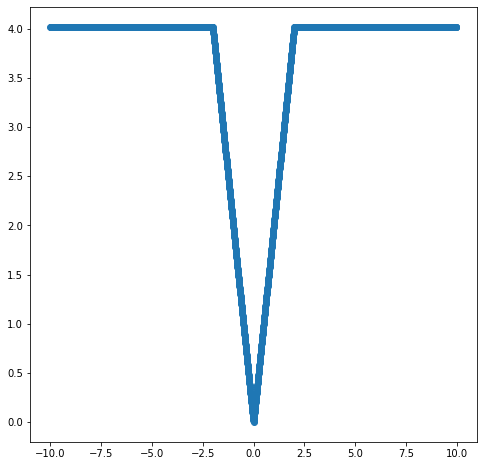

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(beta,y)

## Grid Search application for choosing the optimal hyperparameters.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
model = ElasticNet()
params = [{'alpha':np.linspace(0.001,1,num=50),'l1_ratio':np.linspace(0,1,num=50)}]
gs = GridSearchCV(estimator=model,cv=10,scoring='neg_mean_squared_error',param_grid=params)
gs_results = gs.fit(X,y)
print(gs_results.best_params_)
print('The mean square error is: ', np.abs(gs_results.best_score_))

## Example of Stepwise Regression

In [ ]:
# Implementation of stepwise regression
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

## Ranking Variables (this is relative to the context/model)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=310, max_depth=10,n_estimators=100)
df=pd.get_dummies(df)
model.fit(df,y)

In [ ]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()